In [2]:
import sys
sys.path.insert(0, '../scripts') # ! This wont work now as i moved parse_motifcen  to source
from parse_motifcentral_json import MOTIFCENTRAL 
from get_search_results_from_ENCODE import ENCODE_search 

In [3]:
# MOTIFCENTRAL is a list of JSON objects. Each JSON object corresponds to a single motif.
MOTIFCENTRAL[0].keys()


dict_keys(['modelSettings', 'coefficients', 'metadata'])

In [4]:
print(f"{MOTIFCENTRAL[0]['modelSettings'].keys() = }") 
print(f"{MOTIFCENTRAL[0]['coefficients'].keys() = }") 
print(f"{MOTIFCENTRAL[0]['metadata'].keys() = }") 

MOTIFCENTRAL[0]['modelSettings'].keys() = dict_keys(['letterOrder', 'bindingModes', 'letterComplement'])
MOTIFCENTRAL[0]['coefficients'].keys() = dict_keys(['bindingModes'])
MOTIFCENTRAL[0]['metadata'].keys() = dict_keys(['fit_id', 'factors', 'experiments'])


1. What are all the metadata.factors.gene_symbol in MOTIFCENTRAL?

In [5]:
print(f"{MOTIFCENTRAL[0]['metadata']['factors'][0].keys() = }") # tax_id gives information about the organism. 10090 = Musmusculus 

MOTIFCENTRAL[0]['metadata']['factors'][0].keys() = dict_keys(['gene_symbol', 'gene_name', 'tax_id', 'annotation'])


In [3]:
MOTIFCENTRAL[0]['metadata']['factors']

[{'gene_symbol': 'Tfe3',
  'gene_name': 'transcription factor E3',
  'tax_id': 10090,
  'annotation': [['ENSEMBL_GENE', 'ENSMUSG00000000134'],
   ['ENTREZ', '209446'],
   ['MGI', '98511'],
   ['PFAM', 'PF00010'],
   ['PFAM', 'PF11851'],
   ['PFAM', 'PF15951'],
   ['SWISS_PROT', 'Q64092']]}]

In [8]:
gene_set = {(lambda fit: fit['metadata']['factors'][0]['gene_symbol'])(fit) for fit in MOTIFCENTRAL}
gene_list = list([(lambda fit: fit['metadata']['factors'][0]['gene_symbol'])(fit) for fit in MOTIFCENTRAL])


In [33]:
print(f"Lenght of MOTIFCENTRAL = {len(MOTIFCENTRAL)} \n Lenght of gene_set = {len(gene_set)} \n Lenght of gene_list = {len(gene_list)} \n") 

Lenght of MOTIFCENTRAL = 874 
 Lenght of gene_set = 824 
 Lenght of gene_list = 874 



So we have repeats. Perhaps the same TF in different organisms? TF + Organism should be a unique identifier. The ENTREZ ID Accounts for this.
So how do I find ChIP datasets for a given ENTREZ ID? I need to use the metadata to find my relevant genomic assay.

2. What is the range of number of binding modes? MOTIFCENTRAL[0]['modelSettings']['bindingModes'] or MOTIFCENTRAL[0]['coefficients']['bindingModes']

In [34]:
MOTIFCENTRAL[0]['modelSettings']['bindingModes']


[{'fitLogActivity': True,
  'flankLength': 0,
  'singleStrand': False,
  'size': 12,
  'dinucleotideDistance': 0,
  'componentName': 'Binding mode 1',
  'positionBias': False,
  'modifications': []}]

In [37]:
number_of_BM_range = {(lambda fit: len(fit['coefficients']['bindingModes']))(fit) for fit in MOTIFCENTRAL}
number_of_BM_range


{1}

Okay so we always have one BM. That makes things easier.

In [42]:
MOTIFCENTRAL[0]['coefficients']['bindingModes'][0].keys()

dict_keys(['mononucleotide', 'activity', 'dinucleotide', 'positionBias', 'modifications'])

In [9]:
tax_id_set # So we only have 4 organisms

{7227, 9606, 10090, 94885}

In [12]:
tax_id_set = {(lambda fit: fit['metadata']['factors'][0]['tax_id'])(fit) for fit in MOTIFCENTRAL}
tax_id_dict = {
                7227:"Drosophila+melanogaster", 
                9606:"Homo+sapiens",
                10090:"Mus+musculus",
                94885:"Pantherophis+guttatus"}

In [13]:
# A function that returns inforamtion about fit that I can use to query the ENCODE DB
fit_info = lambda fit: (fit['metadata']['fit_id'], fit['metadata']['factors'][0]['gene_symbol'], fit['metadata']['factors'][0]['tax_id'])

In [17]:
hits = {}
have_hits = 0

for id, gene, taxa in  [fit_info(fit) for fit in MOTIFCENTRAL]:
   search_results = ENCODE_search(gene.upper(), tax_id_dict[taxa])
   hits[id] = len(search_results["@graph"])
   if hits[id] >0: have_hits+=1
   print(f'{gene.upper()} for {tax_id_dict[taxa]} had {hits[id]}.')



TFE3 for Mus+musculus had 0.
GATA3 for Mus+musculus had 0.
EGR1 for Homo+sapiens had 14.
RXRA for Homo+sapiens had 7.
SOX17 for Homo+sapiens had 0.
SP4 for Mus+musculus had 0.
RARG for Mus+musculus had 0.
GSC for Drosophila+melanogaster had 0.
RARG for Homo+sapiens had 1.
VSX1 for Mus+musculus had 0.
MAFB for Mus+musculus had 0.
MAFB for Homo+sapiens had 0.
MAX for Homo+sapiens had 23.
CEBPG for Homo+sapiens had 5.
DBP for Homo+sapiens had 1.
NFIL3 for Homo+sapiens had 1.
DBP for Mus+musculus had 0.
ATF4 for Mus+musculus had 0.
SOX5 for Homo+sapiens had 1.
MLX for Mus+musculus had 0.
NR2F6 for Mus+musculus had 0.
SREBF1 for Mus+musculus had 0.
SREBF2 for Homo+sapiens had 5.
HOMEZ for Homo+sapiens had 2.
PKNOX1 for Homo+sapiens had 4.
EMS for Drosophila+melanogaster had 0.
BSH for Drosophila+melanogaster had 0.
BCD for Drosophila+melanogaster had 0.
DLL for Drosophila+melanogaster had 0.
HR3 for Drosophila+melanogaster had 0.
GCM2 for Drosophila+melanogaster had 0.
TLL for Drosophila+me

In [18]:
have_hits

337

In [19]:
have_hits/len(MOTIFCENTRAL)

0.38558352402745993

In [22]:
hits.values()

dict_values([0, 0, 14, 7, 0, 0, 0, 0, 1, 0, 0, 0, 23, 5, 1, 1, 0, 0, 1, 0, 0, 0, 5, 2, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 7, 9, 5, 0, 0, 1, 2, 0, 0, 0, 0, 0, 3, 1, 0, 0, 8, 0, 0, 0, 0, 2, 0, 8, 2, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 12, 1, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 457, 0, 0, 0, 2, 0, 1, 1, 6, 7, 0, 0, 1, 5, 0, 1, 0, 2, 0, 2, 9, 0, 4, 2, 4, 1, 2, 1, 2, 3, 0, 0, 0, 0, 0, 8, 0, 0, 0, 4, 1, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 2, 0, 2, 1, 8, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 12, 3, 0, 14, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 19, 19, 1, 0, 0, 0, 0, 0, 1

(array([24.,  3.,  8.,  4.,  0.,  1., 16.,  1.,  7.,  2.]),
 array([ 5. ,  6.1,  7.2,  8.3,  9.4, 10.5, 11.6, 12.7, 13.8, 14.9, 16. ]),
 <BarContainer object of 10 artists>)

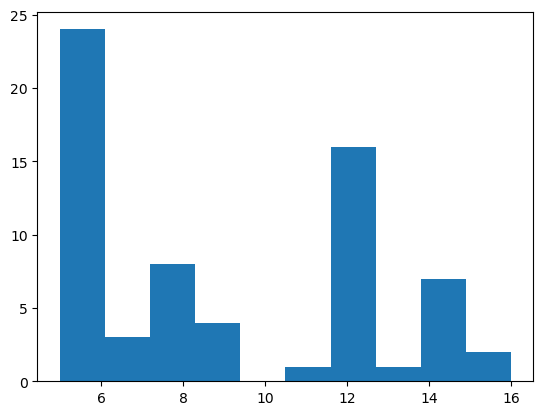

In [26]:
import matplotlib.pyplot as plt


plt.hist(list(hits.values()),range=(5,16))


In [ ]:
# Get index of model given gene name
gene = 'GR'

for i, motif in enumerate(MOTIFCENTRAL):
    if gene in motif['metadata']['factors'][0]['gene_symbol']:
        print(i)

222


In [11]:
MOTIFCENTRAL[222]

{'modelSettings': {'letterOrder': 'ACGT',
  'bindingModes': [{'fitLogActivity': True,
    'flankLength': 0,
    'singleStrand': False,
    'size': 18,
    'dinucleotideDistance': 0,
    'componentName': 'Binding mode 1',
    'positionBias': False,
    'modifications': []}],
  'letterComplement': 'C-G,A-T'},
 'coefficients': {'bindingModes': [{'mononucleotide': [-0.8892676406380744,
     -0.17695740932441772,
     0,
     -0.1906680224545454,
     0,
     -0.2736090466940002,
     -0.32218982223937154,
     -0.5090409965771627,
     -1.094321502733333,
     -1.2095045360613295,
     0,
     -1.4175601915336813,
     -0.5818222024313133,
     0,
     -1.5835424380311665,
     -0.9661045270704722,
     -2.2910094805489507,
     -2.1748712561584336,
     0,
     -1.8172344308689308,
     -1.9136461442114072,
     0,
     -2.0211043009272736,
     -2.53754491416455,
     -2.8599097340573456,
     0,
     -3.184751722068996,
     -2.793320371083581,
     -0.4245389512208142,
     0,
     -1.

In [9]:
MOTIFCENTRAL[13]["coefficients"]["bindingModes"][0]['mononucleotide']

[-0.038763142589396615,
 -0.13191122334958205,
 0,
 -0.1628007128506166,
 -0.1713360048105077,
 0,
 -0.06891111980367448,
 -0.14441890323581408,
 -0.6913516948517531,
 -0.4562045373322672,
 0,
 -0.000557632265413055,
 0,
 -1.751194866226065,
 -0.430016165775819,
 -2.1640772471029788,
 -3.3905916431300236,
 -3.402173256954452,
 -3.5193330959607305,
 0,
 -3.233472293182503,
 -4.155789300356583,
 -1.675808295105874,
 0,
 -0.7294225472925886,
 -3.451088089019582,
 0,
 -1.7419515768521707,
 -2.4330022573130483,
 0,
 -2.4716176379839556,
 -1.626498721615297,
 -1.370751947914326,
 -2.6242176632930985,
 0,
 -2.48343206040465,
 -1.3529142815463429,
 0,
 -3.0060066045186318,
 -0.5921247288245386,
 0,
 -1.0570731289883604,
 -3.4181294651806073,
 -3.5335692319182623,
 -0.04181456473679912,
 0,
 -2.560380716174281,
 -2.9629212117346038,
 -0.3675887706865124,
 -0.3898058260833803,
 -0.11692407308984709,
 0,
 0,
 -0.4345145186557877,
 -0.9350357423634765,
 -0.469741598589116]